# Velocity stream plot: LARRY dataset

Here we'll use the function `sdq.pl.velocity_stream` to plot the drift vector field and overlay this with the magnitude of diffusion. These plots give us an intuitive sense for the relative (low-dimension) direction of cell change alongside the magnitude of stochastic change. We'll apply this plot to the LARRY dataset, performing the necessary prerequisite operations, including the following functions:

1. `sdq.tl.drift` (accessed also as `model.drift()` where `model` is an `sdq.scDiffEq` model.

2. `sdq.tl.diffusion` (accessed also as `model.diffusion()` where `model` is an `sdq.scDiffEq` model.

3. `sdq.tl.velocity_graph`

### Import libraries

In [1]:
%load_ext nb_black

import scdiffeq as sdq
import pathlib
import cellplots as cp
import matplotlib.pyplot as plt
import larry

larry_cmap = larry.pl.InVitroColorMap()._dict

print(sdq.__version__, sdq.__path__)

0.1.1rc0 ['/home/mvinyard/github/scDiffEq/scdiffeq']


<IPython.core.display.Javascript object>

### Load data

In [2]:
h5ad_path = (
    "/home/mvinyard/data/adata.reprocessed_19OCT2023.more_feature_inclusive.h5ad"
)
adata = sdq.io.read_h5ad(h5ad_path)

AnnData object with n_obs × n_vars = 130887 × 2492
    obs: 'Library', 'Cell barcode', 'Time point', 'Starting population', 'Cell type annotation', 'Well', 'SPRING-x', 'SPRING-y', 'clone_idx', 'fate_observed', 't0_fated', 'train'
    var: 'gene_ids', 'hv_gene', 'must_include', 'exclude', 'use_genes'
    uns: 'fate_counts', 'h5ad_path', 'time_occupance'
    obsm: 'X_clone', 'X_pca', 'X_umap', 'cell_fate_df'
    layers: 'X_scaled'


<IPython.core.display.Javascript object>

### Load the model checkpoint

Here, we'll use a model checkpoint that was trained on the full LARRY dataset (further studied in Figure 4).

In [3]:
ckpt_path = pathlib.Path(
    "/home/mvinyard/experiments/LARRY.full_dataset/LightningSDE-FixedPotential-RegularizedVelocityRatio/version_0/checkpoints/last.ckpt"
)
model = sdq.io.load_model(adata=adata, ckpt_path=ckpt_path)

 - [INFO] | Input data configured.
 - [INFO] | Bulding Annoy kNN Graph on adata.obsm['train']


Seed set to 0


 - [INFO] | Using the specified parameters, LightningSDE-FixedPotential-RegularizedVelocityRatio has been called.


<IPython.core.display.Javascript object>

### Compute the snapshot drift and diffusion

We'll call the operations using the functions built into the model class. This will pass the data stored in the `model.adata` object through the functions. These can also be called independently on a different adata object through the `sdq.tl.` part of the API.

In [4]:
model.drift()
model.diffusion()

 - [INFO] | Added: adata.obsm['X_drift']
 - [INFO] | Added: adata.obsm['drift']
 - [INFO] | Added: adata.obsm['X_diffusion']
 - [INFO] | Added: adata.obsm['diffusion']


<IPython.core.display.Javascript object>

Smooth the data using kNN

In [5]:
smoother = sdq.tl.kNNSmoothing(model.adata)
model.adata.obs["smooth.diffusion"] = smoother("diffusion")
df_inspect = model.adata.obs[["diffusion", "smooth.diffusion"]]
df_inspect.min(), df_inspect.max()

(diffusion           0.202671
 smooth.diffusion    0.264766
 dtype: float32,
 diffusion           99.265465
 smooth.diffusion    45.804302
 dtype: float32)

<IPython.core.display.Javascript object>

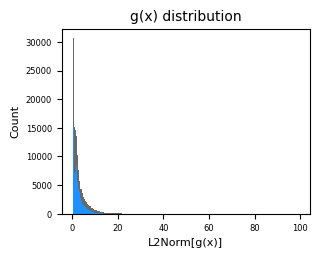

<IPython.core.display.Javascript object>

In [6]:
fig, axes = cp.plot(
    height=0.5,
    width=0.5,
    title=["g(x) distribution"],
    x_label=["L2Norm[g(x)]"],
    y_label=["Count"],
)
b2 = axes[0].hist(model.adata.obs["diffusion"], bins=210, color="dimgrey")
b1 = axes[0].hist(model.adata.obs["smooth.diffusion"], bins=210, color="dodgerblue")

### Compute velocity graph and plot

We'll use the velocity components we've just computed to compute the velocity graph that will ultimately enable us to build a low-dimension vector field. 

**Note**: Since we've performed these operations on the `model.adata` object, we'll use that in this function, directly.

In [7]:
sdq.tl.velocity_graph(model.adata)

 - [INFO] | Added: adata.obsp['distances']
 - [INFO] | Added: adata.obsp['connectivities']
 - [INFO] | Added: adata.uns['neighbors']
 - [INFO] | Added: adata.obsp['velocity_graph']
 - [INFO] | Added: adata.obsp['velocity_graph_neg']


<IPython.core.display.Javascript object>

The following is the plot shown in Figure 2b of the manuscript.

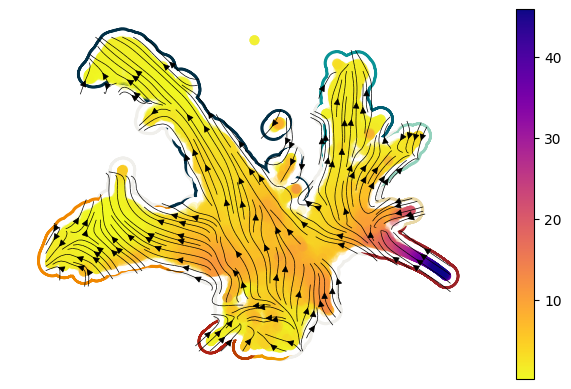

<IPython.core.display.Javascript object>

In [8]:
fig, axes = cp.plot(1, 1, height=1, width=1.2, del_xy_ticks=[True], delete="all")
ax = axes[0]
axes = cp.umap_manifold(
    adata,
    groupby="Cell type annotation",
    c_background=larry_cmap,
    ax=ax,
    s_background=350,
    s_cover=200,
)
sdq.pl.velocity_stream(
    model.adata,
    c="smooth.diffusion",
    cutoff_percentile=0.1,
    ax=ax,
    scatter_zorder=101,
    stream_zorder=201,
    scatter_kwargs={"rasterized": True},
)
plt.savefig("LARRY.example_velocity_stream.svg", dpi=500)